#ML4Net - Lab 3

## Team members

Marc Mallol 268923 | Jordi Esteve 268829 | Albert Jané 268537

## Description

In this lab, you will train a time series forecaster using Federated Learning (FL).

The dataset you are going to use contains data from multiple APs. In particular, each AP's dataset contains the following features:

* `datetime` is the timestamp (date) at which the measurement was taken
* `Bytes` is the number of Bytes contributed at the corresponding datetime
* `Active Connections` is the number of active connections (users connected to the AP) at the corresponding datetime
* `Active Users` is the number of active users at the corresponding datetime
* `AP ID` is the ID of the AP where the measurement was taken

Original dataset: Chen, W., Lyu, F., Wu, F., Yang, P., & Ren, J. (2021). Flag: Flexible, accurate, and long-time user load prediction in large-scale WiFi system using deep RNN. IEEE Internet of Things Journal, 8(22), 16510-16521.

## Instructions

*   Follow the steps from this Notebook and complete the proposed exercises.
*   Deliver the completed Notebook by uploading it to your Github repository.
*   **Submission deadline: 8 June 2025 (EoB).**

## Setting up the environment

In [9]:
import os
import urllib.request

dataset_url = "https://github.com/fwilhelmi/fwilhelmi.github.io/raw/master/files/datasetLab3.pkl"
dataset_path = "datasetLab3.pkl"

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Download complete.")
else:
    print("Dataset already exists:", dataset_path)

Dataset already exists: datasetLab3.pkl


## Loading the data




Load the data from the pickle file (https://docs.python.org/3/library/pickle.html) that contains the dataset.

**Important:** If you have issues with the dataset after automatically downloading and extracting it, download it and move it manually to the indicated folder.

In [10]:
import pickle
import os

print(os.getcwd())
print(os.path.exists('datasetLab3.pkl'))

try:
    with open('datasetLab3.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    print("Data loaded successfully:")
    print(loaded_data)
except FileNotFoundError:
    print("Error: 'datasetLab3.pkl' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

/mnt/c/Users/Marc/Documents/Uni/3r/3r Trimestre/MLNetworks/Labs/ML4Net-2025/Lab3
True
Data loaded successfully:
                     Bytes  Active Connections  Active Users   AP ID
datetime                                                            
2019-04-30 07:10:00    0.0            0.075209           0.0  7-1012
2019-04-30 07:20:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:30:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:40:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:50:00    0.0            0.000000           0.0  7-1012
...                    ...                 ...           ...     ...
2019-05-14 07:10:00    0.0            0.000000           0.0   7-104
2019-05-14 07:20:00    0.0            0.000000           0.0   7-104
2019-05-14 07:30:00    0.0            0.000000           0.0   7-104
2019-05-14 07:40:00    0.0            0.000000           0.0   7-104
2019-05-14 07:50:00    0.0            0.034091           0.0

# Exercise 0: Data Exploration

We know this is not a requirement, but still we want do explore the data a bit.

Before we build any models, it’s essential to get our hands dirty with the raw data.  A solid exploration step helps us:

1. **Verify assumptions** about how the data is recorded (time-index, AP grouping, units).
2. **Spot anomalies** or quirks (long runs of zeros, extreme outliers) that could trip up our LSTM.
3. **Plan preprocessing** (scaling, log-transforms, imputation) and feature engineering more intelligently.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.DataFrame(loaded_data)

display(loaded_data)  

,Bytes,Active Connections,Active Users,AP ID
datetime,,,,
2019-04-30 07:10:00,0.0,0.075209,0.0,7-1012
2019-04-30 07:20:00,0.0,0.000000,0.0,7-1012
2019-04-30 07:30:00,0.0,0.000000,0.0,7-1012
2019-04-30 07:40:00,0.0,0.000000,0.0,7-1012
2019-04-30 07:50:00,0.0,0.000000,0.0,7-1012
...,...,...,...,...
2019-05-14 07:10:00,0.0,0.000000,0.0,7-104
2019-05-14 07:20:00,0.0,0.000000,0.0,7-104
2019-05-14 07:30:00,0.0,0.000000,0.0,7-104


In [12]:
display(df.describe())

,Bytes,Active Connections,Active Users
count,2.110640e+05,211064.000000,211064.000000
mean,3.693131e+04,1.582982,1.200613
std,1.441261e+05,4.446037,3.739401
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,0.000000e+00,0.000000,0.000000
75%,2.680175e+03,1.353333,1.000000
max,3.993286e+06,103.780000,79.000000


In [13]:
display(df['AP ID'].unique())

array(['7-1012', '7-1013', '7-1021', '7-1043', '7-1019', '7-1071',
       '7-1113', '7-1048', '7-1101', '7-1026', '7-1129', '7-112', '7-100',
       '7-111', '7-1030', '7-1117', '7-1126', '7-1099', '7-1052',
       '7-1087', '7-108', '7-1022', '7-1018', '7-1059', '7-1054', '7-110',
       '7-1058', '7-1094', '7-1064', '7-102', '7-1044', '7-1002',
       '7-1096', '7-1014', '7-1082', '7-1088', '7-1106', '7-1063',
       '7-1114', '7-1137', '7-1004', '7-1045', '7-1125', '7-1036',
       '7-1124', '7-1034', '7-1083', '7-1072', '7-1033', '7-1069',
       '7-1127', '7-1005', '7-1130', '7-1047', '7-1020', '7-1066',
       '7-1039', '7-1134', '7-1003', '7-1120', '7-1131', '7-1009',
       '7-1084', '7-1074', '7-1062', '7-1025', '7-1089', '7-1098',
       '7-1006', '7-1139', '7-10', '7-1133', '7-1060', '7-1032', '7-106',
       '7-1057', '7-101', '7-1102', '7-1085', '7-1053', '7-107', '7-1121',
       '7-1023', '7-1097', '7-1050', '7-1037', '7-11', '7-1136', '7-1040',
       '7-1015', '7-1079'

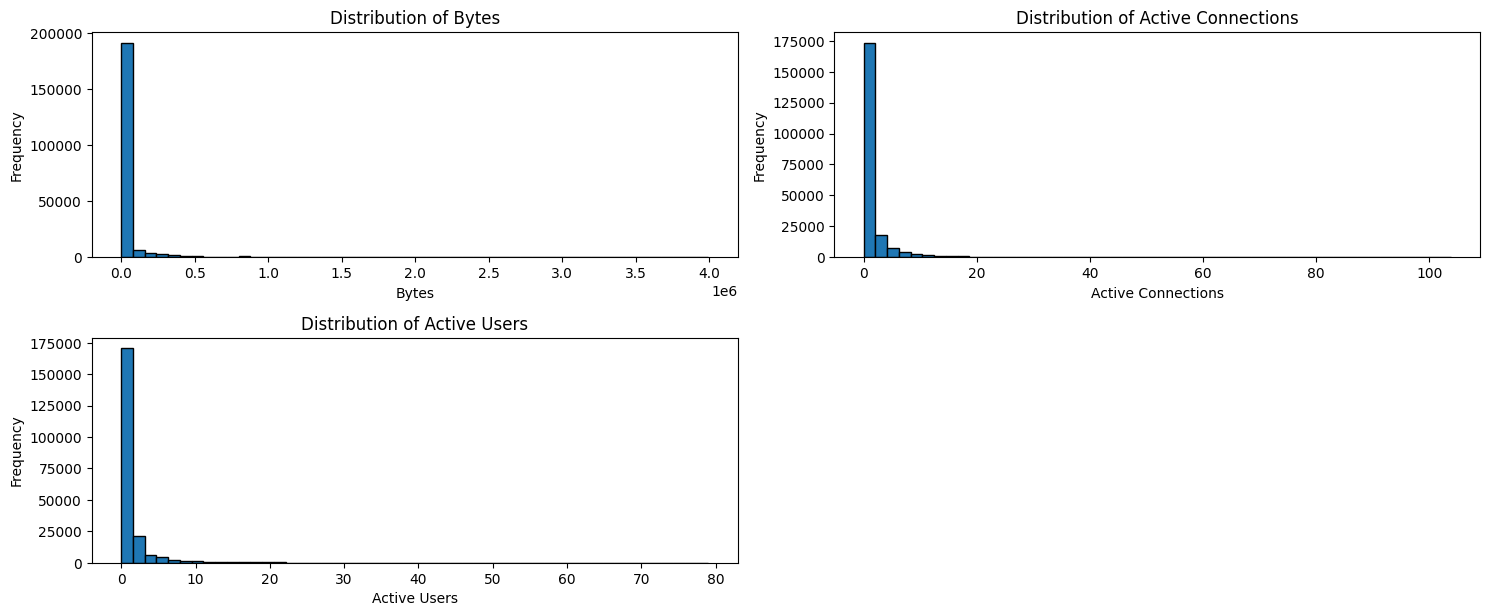

In [14]:
columns_to_plot = [ 'Bytes', 'Active Connections', 'Active Users']

plt.figure(figsize=(15, 15))  # Set the figure size (width, height) in inches

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(5, 2, i)
    plt.hist(df[col], bins=50, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Comment

We know this is not an exercise, but it is interesting and useful to see how data is structured and given tu us, in order to make our decissions better.

* We can see that the data has 3 main features, `#Bytes`, `#Active Connections`, `# Active users`. The indexes of the df, are the time-stamps. 

* All three series are heavily **right-skewed**: most values are zero, but there are occasional large outliers. These peaks carry the key signal for predicting future throughput.

## EXERCISES

### Exercise 1:

Analyze the data from the different APs and discuss their properites (stationarity, trends, seasonality).

Select 2 or 3 key APs showing different properties and generate:

* Line plots (to plot the load vs the time)
* Autocorrelation plots (to show the relationship between past and future samples of the load)
* An Augmented Dickey-Fuller test (to study the stationarity of the AP)



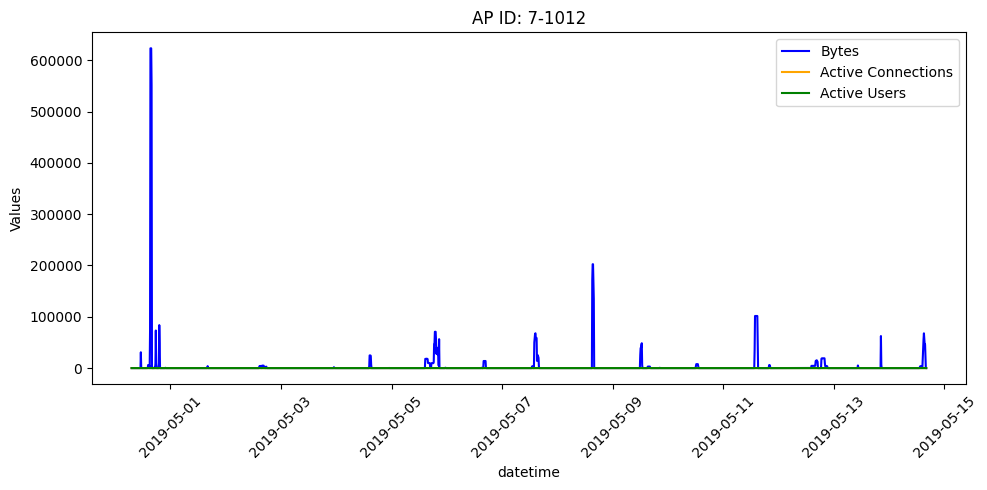

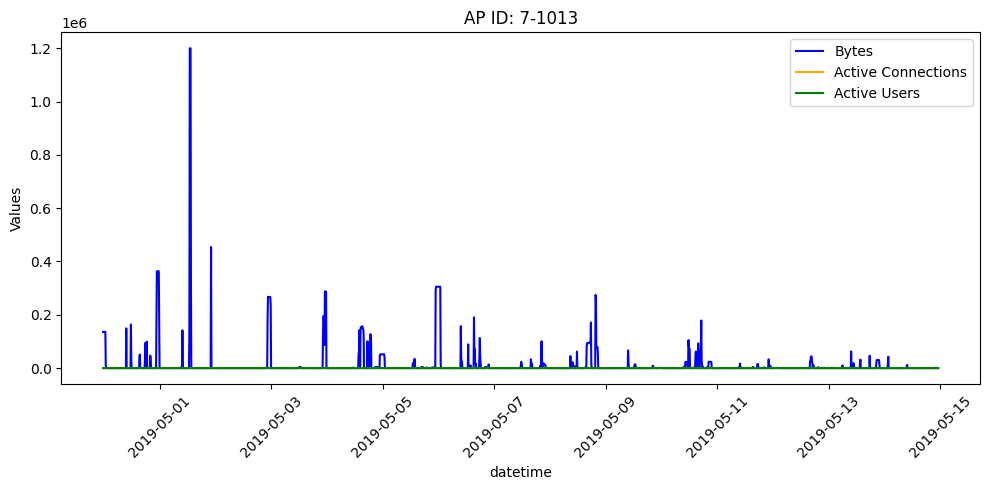

In [15]:
# (response to exercise 1)

selected_APs= df['AP ID'].unique()[:2]  # Select first 3 AP IDs
for ap_id in selected_APs:
    ap_data = df[df['AP ID'] == ap_id]
    plt.figure(figsize=(10, 5))
    plt.plot(ap_data.index, ap_data['Bytes'], label='Bytes', color='blue')
    plt.plot(ap_data.index, ap_data['Active Connections'], label='Active Connections', color='orange')
    plt.plot(ap_data.index, ap_data['Active Users'], label='Active Users', color='green')
    plt.title(f'AP ID: {ap_id}')
    plt.xlabel('datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Comment on Line Plots

For both cases we can see that most of the time users, bytes and connections are 0, with some peaks regading bytes in both cases. 

**AP 7-1012**  
- Baseline sits at zero for most timestamps, punctuated by **sporadic bursts** in bytes (e.g. ~600 KB on 2019-05-01, ~200 KB on 05-09).  
- Active connections/users jump only at those same instants, implying brief, small-scale sessions.  
- No clear daily or weekly cycles—traffic appears **event‐driven** rather than periodic.

**AP 7-1013**  
- Even larger, less frequent spikes (up to ~1.2 MB), sometimes sustained for multiple intervals, suggesting **longer sessions**.  
- Long stretches of complete inactivity in between—this series is extremely **sparse**.  
- Again, no stable seasonality; bursts cluster around certain dates but not at fixed times of day.

With this we can see that each individual AP behaves on its own way, not necessarily dependent on any other AP

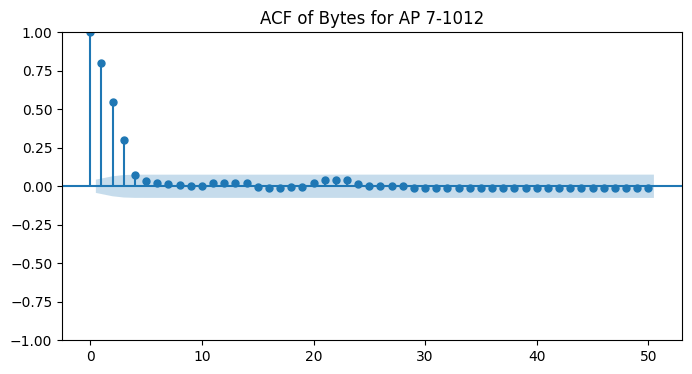

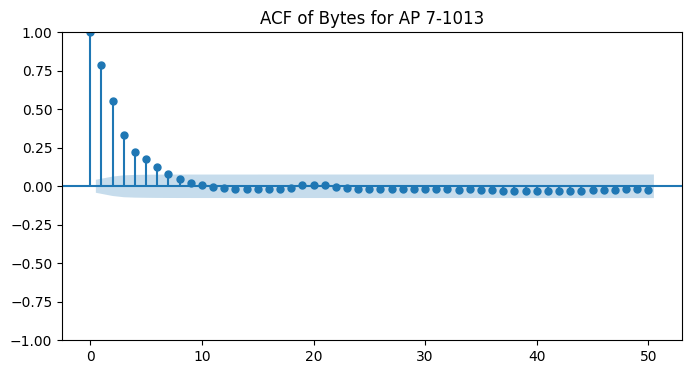

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

for ap_id in selected_APs:
    ap_data = df[df['AP ID'] == ap_id]['Bytes']
    fig, ax = plt.subplots(figsize=(8,4))
    plot_acf(ap_data, lags=50, ax=ax) 
    ax.set_title(f'ACF of Bytes for AP {ap_id}')
    plt.show()

# Comment on Autocorrelation Plots

Autocorrelation (ACF) tells us how much the value at time _t_ predicts the value at time _t + lag_. In other words, it measures the “memory” of the series.


## What the plots show

1. **Strong short-lag correlation**  
   - At **lag 1–2**, the ACF sits around 0.6–0.8: a byte-spike now almost guarantees elevated traffic in the next one or two intervals.  
   
2. **Rapid decay to noise**  
   - By **lag 5–6**, correlations fall within the 95 % confidence bands (≈ 0), so beyond ~5 steps the series behaves like white noise.  

3. **No periodic structure**  
   - There are no regular peaks at longer lags—no daily or weekly cycles to exploit.


## Modeling implications

- **Choose a short observation window** Capturing only the first ones, maybe the first 5 ones, captures most of the correlation, therefore no need for a window of 60. 

- **Drop long-range dependencies**: training on longer windows is unlikely to add value and only increases computational cost.  

- **Federated setup**: every AP client can use the same short window, since each series shows the same rapid ACF decay.

In summary, the ACF plots confirm that **most predictive power lives in the first few lags**, so both our centralized LSTM and federated‐learning loops should focus on very recent history.

In [17]:
from statsmodels.tsa.stattools import adfuller

for ap_id in selected_APs:
    ap_data = df[df['AP ID'] == ap_id]
    print(f"\nADF Test for AP ID: {ap_id}")
    result = adfuller(ap_data['Bytes'].dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("=> The series is likely stationary.")
    else:
        print("=> The series is likely non-stationary.")


ADF Test for AP ID: 7-1012
ADF Statistic: -8.0108
p-value: 0.0000
Critical Value 1%: -3.4336
Critical Value 5%: -2.8630
Critical Value 10%: -2.5675
=> The series is likely stationary.

ADF Test for AP ID: 7-1013
ADF Statistic: -14.6033
p-value: 0.0000
Critical Value 1%: -3.4334
Critical Value 5%: -2.8629
Critical Value 10%: -2.5675
=> The series is likely stationary.


# Comment on ADF Test

We can see that both AP are stationary. What this means is that the mean of bytes does not follow a given trend by a certain amount of time (on the long term, *months*). This is a keyinsight, as we do not need to worry about the time of the input at all, rather it could be convenient to add it as a feature as it can provide some information (in the short term, *minutes, hours*)

### Exercise 2:

Prepare the data to be presented as a time series to the ML model. For that, you will have to split features from samples by differentiating between an observation window (e.g., 10 samples) and a prediction window (e.g., 2 samples). Use a sliding window to iterate over all the samples.

Example: For an array [0,1,2,3,4,5], using an observation window $T_o$ = 3 and a prediction window $T_p$ = 1 would lead to the following time series data:
* $x_1$ = [0,1,2], $y_1$ = [3]
* $x_2$ = [1,2,3], $x_2$ = [4]
* $x_3$ = [2,3,4], $y_3$ = [5]

(where x are the features and y the labels)

In [18]:
T_o = 3   # observation window
T_p = 1   # prediction window
feature_cols = ['Bytes', 'Active Connections', 'Active Users']
target_col = 'Bytes'

# 1) Build per‐AP windows exactly once
ap_windows = {}
df_sorted = df.sort_index()
for ap_id in df_sorted['AP ID'].unique():
    ap = df_sorted[df_sorted['AP ID'] == ap_id]
    feats = ap[feature_cols].values      # (n_samples, 3)
    targ  = ap[target_col].values        # (n_samples,)
    X_ap, y_ap = [], []
    for i in range(len(ap) - T_o - T_p + 1):
        X_ap.append(feats[i : i + T_o])                     # (T_o, 3)
        y_ap.append(targ[i + T_o : i + T_o + T_p])          # (T_p,)
    ap_windows[ap_id] = (np.array(X_ap), np.array(y_ap))

# Sanity check: total windows should match earlier counts
total_windows = sum(X.shape[0] for X, _ in ap_windows.values())
print("Total sliding windows:", total_windows)

Total sliding windows: 210764


In [19]:
print(X_ap[:1])  

[array([[0.        , 0.01417004, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.06333333, 0.        ]])]


In [20]:
print(y_ap[:1])

[array([0.])]


# Comment on Exercise 2

Now, we have the data standarized and prepared, separated into X and y and agruppated in time series, we are ready to discuss the approach for dividing the dataset into training, test and validation.

### Exercise 3:

Split the time series data into train, test, and validation, based on your criteria.

In [21]:
from sklearn.preprocessing import StandardScaler

X_train_list, X_val_list, X_test_list = [], [], []
y_train_list, y_val_list, y_test_list = [], [], []

for X_ap, y_ap in ap_windows.values():
    n = X_ap.shape[0]
    train_end = int(0.6 * n)
    val_end   = int(0.8 * n)

    X_train_list.append(X_ap[:train_end])
    y_train_list.append(y_ap[:train_end])

    X_val_list.append(X_ap[train_end:val_end])
    y_val_list.append(y_ap[train_end:val_end])

    X_test_list.append(X_ap[val_end:])
    y_test_list.append(y_ap[val_end:])

# Concatenate across all APs
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_val   = np.concatenate(X_val_list,   axis=0)
y_val   = np.concatenate(y_val_list,   axis=0)
X_test  = np.concatenate(X_test_list,  axis=0)
y_test  = np.concatenate(y_test_list,  axis=0)

print("Shapes before scaling:")
print(" X_train:", X_train.shape, "y_train:", y_train.shape)
print(" X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print(" X_test: ", X_test.shape,  "y_test: ", y_test.shape)

# Scale features using ONLY the training set
scaler_X = StandardScaler()
# Reshape to 2D: (samples * timesteps, features)
n_train, to, f = X_train.shape
X_train_2d = X_train.reshape(-1, f)
scaler_X.fit(X_train_2d)

# Transform and reshape back
X_train = scaler_X.transform(X_train_2d).reshape(n_train, to, f)
for arr_name in ['X_val', 'X_test']:
    arr = locals()[arr_name]
    n_arr = arr.shape[0]
    arr_2d = arr.reshape(-1, f)
    scaled = scaler_X.transform(arr_2d).reshape(n_arr, to, f)
    locals()[arr_name] = scaled

print("\nShapes after scaling:")
print(" X_train:", X_train.shape)
print(" X_val:  ", X_val.shape)
print(" X_test: ", X_test.shape)

# Scale y using ONLY the training set
scaler_y = StandardScaler()
# Reshape to 2D: (samples, targets)
y_train_2d = y_train.reshape(-1, y_train.shape[-1])
scaler_y.fit(y_train_2d)

# Transform and reshape back
y_train = scaler_y.transform(y_train_2d).reshape(y_train.shape)
for arr_name in ['y_val', 'y_test']:
    arr = locals()[arr_name]
    arr_2d = arr.reshape(-1, arr.shape[-1])
    scaled = scaler_y.transform(arr_2d).reshape(arr.shape)
    locals()[arr_name] = scaled

print("\nShapes after scaling y:")
print(" y_train:", y_train.shape)
print(" y_val:  ", y_val.shape)
print(" y_test: ", y_test.shape)

Shapes before scaling:
 X_train: (126418, 3, 3) y_train: (126418, 1)
 X_val:   (42152, 3, 3) y_val:   (42152, 1)
 X_test:  (42194, 3, 3) y_test:  (42194, 1)

Shapes after scaling:
 X_train: (126418, 3, 3)
 X_val:   (42152, 3, 3)
 X_test:  (42194, 3, 3)

Shapes after scaling y:
 y_train: (126418, 1)
 y_val:   (42152, 1)
 y_test:  (42194, 1)


# Comment on exercise 3

With a 60% train, a 20% val and a 20% test, the dataset is big enough to learn, test and validate our results with enoguh confidence to give certain conclussions. If the dataset was not big enough, we would have to do other configuration to ensure a better training in exchange for worse validation, but looking at the results,
* Training set shape: (126458, 3, 3) (126458, 1)
* Validation set shape: (42153, 3, 3) (42153, 1)
* Test set shape: (42153, 3, 3) (42153, 1)

The sizes are big enough to have all of it.

Important to notice that in order to avoid any data leakage, the standarization has been done after spliting the dataset.

### Exercise 4:
Define a model (e.g., GRU, LSTM, CNN, Transformer) able to receive the time series the data you generated in the previous exercise.

In [22]:
# (response to exercise 4)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

def create_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(128,
                         return_sequences=True,
                         dropout=0.1,
                         kernel_regularizer=regularizers.l2(1e-6),
                         input_shape=input_shape))
    model.add(layers.LSTM(64,
                         dropout=0.1,
                         kernel_regularizer=regularizers.l2(1e-6)))
    model.add(layers.Dense(32,
                           activation='relu',
                           kernel_regularizer=regularizers.l2(1e-6)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(1e-2),
                  loss='mse')
    return model


2025-06-10 12:36:40.838849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 12:36:40.866905: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 12:36:40.896750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749551800.928290    2312 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749551800.938641    2312 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749551800.986630    2312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Comment on exercise 4

As we can see, the model is a sequential LSTM model with two LSTM layers, a dense layer, and a dropout layer. The model is compiled with the Adam optimizer and mean squared error loss function.

We've added this to try to learn the non-linear relations between the features.

Playing a bit with the model, some dropout has been added to help with generalization.

The learning rate is a bit high (1e-2) as we have seen that this helps the model learn the relations of the data faster and avoid local minima with ease.

### Exercise 5:

Train your model following two approaches:
1. **Centralized model training:** Mix data from multiple APs to train the model in a centralized fashion.
2. **Federated model training:** Consider APs as independent clients who contribute to training a global model by submitting local model updates.

Show the results by calculating the following metrics from the de-normalized data:
* Mean squared error (MSE)
* Mean absolute error (MAE)
* Mean absolute percentage error (MAPE)

# Centralized model

In [23]:
# (response to exercise 5)

# Create the model centralized around the LSTM architecture
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
# Train the model
callbacks = [
    keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=5)
]

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=callbacks)
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")



Epoch 1/100


E0000 00:00:1749551802.935609    2312 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749551802.936812    2312 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/marc/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3951/3951 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.2694 - val_loss: 0.0868 - learning_rate: 0.0100
Epoch 2/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1943 - val_loss: 0.1042 - learning_rate: 0.0100
Epoch 3/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1871 - val_loss: 0.0811 - learning_rate: 0.0100
Epoch 4/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1871 - val_loss: 0.0828 - learning_rate: 0.0100
Epoch 5/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1833 - val_loss: 0.0876 - learning_rate: 0.0100
Epoch 6/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1944 - val_loss: 0.0783 - learning_rate: 0.0100
Epoch 7/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1698 - val_loss: 0.0801 - learning_rate: 0.0100
Epoch 8/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.1793 - val_loss: 0.0816 - learning_rate: 0.0100
Epoch 9/100
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.1935 - val_loss: 0.0949 - learning

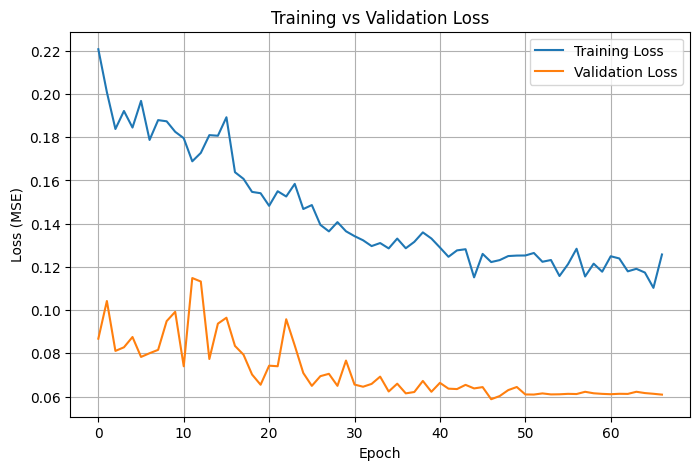

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test)

# If y is 2D (e.g., (samples, T_p)), compute R² for each output
if y_pred.shape[1] == 1 or len(y_pred.shape) == 1:
    r2 = r2_score(y_test, y_pred)
    print(f"R² score: {r2:.4f}")
else:
    for i in range(y_pred.shape[1]):
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        print(f"R² score for output {i}: {r2:.4f}")

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
R² score: 0.8676


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred_un_normalized = scaler_y.inverse_transform(y_pred)
y_true_un_normalized = scaler_y.inverse_transform(y_test)

# --- 6) Compute metrics on de-normalized data ---------------------------

mse  = mean_squared_error(y_true_un_normalized, y_pred_un_normalized)
mae  = mean_absolute_error(y_true_un_normalized, y_pred_un_normalized)

# MAPE with a small epsilon to avoid division by zero, since there are many zeros in the dataset and provide errors in the computation
epsilon = 1e-5  
mask = y_true_un_normalized > epsilon
safe_mape = np.mean(np.abs(
    (y_pred_un_normalized[mask] - y_true_un_normalized[mask]) 
    / np.maximum(y_true_un_normalized[mask], epsilon)
)) * 100

print(f"Test MSE : {mse:.2f}")
print(f"Test MAE : {mae:.2f}")
print(f"Test MAPE (zeros excluded): {safe_mape:.2f}%")

Test MSE : 704118088.33
Test MAE : 7323.00
Test MAPE (zeros excluded): 23264.16%


# Comment on Centralized Learning

For training the model we have setted two callback functions;

* EarlyStopping, so that when the model reaches a point where the validation loss starts increasing and the trainig loss keeps going down, the training stops to avoid overfiiting

* ReduceLROnPlateau, to make the Learning Rate go down whenever the validation loss does not improve after a certain patience and avoid leaving a certain minimum.


We can see that the MSE starts high and decreases constatly in both training and validation, and the early stopping, acts when both of the errors stabilize to avoid overfitting.

The fact that the validation loss is lower than the training loss can be attributed to two main things

* The model is generalizing good enough

* The train-loss is computed whit drop out active, but the validation is not, therefore generalizing better


With this R^2 we can see that the model is significant on predicting the results

# Federated Learning

In [27]:
import numpy as np
import tensorflow as tf

# Hyper-params
T_o = 3   # observe 3 timesteps
T_p = 1   # predict 1 timestep
feature_cols = ['Bytes', 'Active Connections', 'Active Users']
target_col   = 'Bytes'

# This dict will hold each AP's windows
ap_data = {}

# Sort once
df_sorted = df.sort_index()

for ap_id in df_sorted['AP ID'].unique():
    ap_df = df_sorted[df_sorted['AP ID'] == ap_id]
    feat = ap_df[feature_cols].values
    targ = ap_df[target_col].values

    X_list, y_list = [], []
    # sliding window
    for i in range(len(ap_df) - T_o - T_p + 1):
        X_list.append(feat[i : i+T_o])
        y_list.append(targ[i+T_o : i+T_o+T_p])

    # Stack into numpy arrays
    ap_data[ap_id] = (
        np.array(X_list),   # shape (n_windows, T_o, 3)
        np.array(y_list)    # shape (n_windows, T_p)
    )

# Quick sanity check
for ap_id, (X_ap, y_ap) in ap_data.items():
    print(ap_id, X_ap.shape, y_ap.shape)


7-1050 (2326, 3, 3) (2326, 1)
7-1057 (2358, 3, 3) (2358, 1)
7-1023 (2361, 3, 3) (2361, 1)
7-105 (2308, 3, 3) (2308, 1)
7-1114 (2353, 3, 3) (2353, 1)
7-1099 (2296, 3, 3) (2296, 1)
7-1058 (2213, 3, 3) (2213, 1)
7-1085 (2227, 3, 3) (2227, 1)
7-107 (2229, 3, 3) (2229, 1)
7-1051 (2154, 3, 3) (2154, 1)
7-1130 (2238, 3, 3) (2238, 1)
7-1003 (2216, 3, 3) (2216, 1)
7-1072 (2214, 3, 3) (2214, 1)
7-1009 (2227, 3, 3) (2227, 1)
7-1120 (2184, 3, 3) (2184, 1)
7-1124 (2207, 3, 3) (2207, 1)
7-104 (2111, 3, 3) (2111, 1)
7-1033 (2158, 3, 3) (2158, 1)
7-1079 (2177, 3, 3) (2177, 1)
7-1129 (2180, 3, 3) (2180, 1)
7-110 (2161, 3, 3) (2161, 1)
7-1100 (2147, 3, 3) (2147, 1)
7-1026 (2160, 3, 3) (2160, 1)
7-1139 (2146, 3, 3) (2146, 1)
7-1013 (2155, 3, 3) (2155, 1)
7-1020 (305, 3, 3) (305, 1)
7-1113 (2153, 3, 3) (2153, 1)
7-1126 (2146, 3, 3) (2146, 1)
7-1117 (2145, 3, 3) (2145, 1)
7-1134 (2153, 3, 3) (2153, 1)
7-10 (2092, 3, 3) (2092, 1)
7-1030 (2159, 3, 3) (2159, 1)
7-1019 (2157, 3, 3) (2157, 1)
7-1006 (2122, 3, 3

In [28]:
client_data = {}

for ap_id, (X_ap, y_ap) in ap_data.items():
    # 1a) Chronological split into train/val/test (e.g. 70/20/10)
    n = X_ap.shape[0]
    n_test  = int(0.10 * n)
    n_val   = int(0.20 * n)
    n_train = n - n_val - n_test

    X_tr, y_tr = X_ap[:n_train],        y_ap[:n_train]
    X_va, y_va = X_ap[n_train:n_train+n_val], y_ap[n_train:n_train+n_val]
    X_te, y_te = X_ap[-n_test:],        y_ap[-n_test:]

    # 1b) Fit scalers *only* on the TRAIN split
    n_feat = X_tr.shape[-1]
    scaler_X = StandardScaler().fit(X_tr.reshape(-1, n_feat))
    scaler_y = StandardScaler().fit(y_tr.reshape(-1, 1))

    # 1c) Transform each split
    def scale_split(X, y):
        X2 = scaler_X.transform(X.reshape(-1, n_feat)).reshape(X.shape)
        y2 = scaler_y.transform(y.reshape(-1, 1)).reshape(y.shape)
        return X2, y2

    X_tr_s, y_tr_s = scale_split(X_tr, y_tr)
    X_va_s, y_va_s = scale_split(X_va, y_va)
    X_te_s, y_te_s = scale_split(X_te, y_te)

    client_data[ap_id] = {
        'X_train': X_tr_s, 'y_train': y_tr_s,
        'X_val':   X_va_s, 'y_val':   y_va_s,
        'X_test':  X_te_s, 'y_test':  y_te_s,
        'scaler_X': scaler_X, 'scaler_y': scaler_y
    }

In [29]:
client_loaders = {}

for cid, data in client_data.items():
    ds_train = (
        tf.data.Dataset
          .from_tensor_slices((data['X_train'], data['y_train']))
          .shuffle(100, seed=42)
          .batch(32)
    )
    ds_val = (
        tf.data.Dataset
          .from_tensor_slices((data['X_val'], data['y_val']))
          .batch(32)
    )
    client_loaders[cid] = {
        'train': ds_train,
        'val':   ds_val
    }

def initialize_global_model(input_shape):
    """Instantiate a fresh model and return its initial weights."""
    model = create_lstm_model(input_shape)
    return model, model.get_weights()


# Grab the input shape from any client (all are the same)
any_client = next(iter(client_data.values()))
input_shape = any_client['X_train'].shape[1:]  # (T_o, n_feat)

def initialize_global_model(input_shape):
    """Instantiate a fresh model and return its initial weights."""
    model = create_lstm_model(input_shape)
    return model, model.get_weights()


In [30]:
def local_train(global_w, client_ds, lr=1e-3, epochs=1):
    # Clone, load, compile
    m = create_lstm_model(input_shape)
    m.set_weights(global_w)
    if hasattr(m.optimizer.learning_rate, 'assign'):
        m.optimizer.learning_rate.assign(lr)
    else:
        m.optimizer.learning_rate = lr
    # Fit
    m.fit(client_ds, epochs=epochs, verbose=0)
    return m.get_weights()

In [31]:
def fedavg(weight_list, sizes):
    total = sum(sizes)
    avg = [np.zeros_like(w) for w in weight_list[0]]
    for w, sz in zip(weight_list, sizes):
        for i, layer in enumerate(w):
            avg[i] += layer * (sz / total)
    return avg


In [32]:
import random
def federated_train(
    ap_data,
    input_shape,
    rounds=10,
    clients_per_round=10,   # sample 10 APs each round
    local_epochs=1,
    lr=1e-3,
    X_train_eval=None,
    y_train_eval=None,
    X_val=None,
    y_val=None,
):
    # Init
    global_model, global_w = initialize_global_model(input_shape)
    cids = list(ap_data.keys())

    train_losses, val_losses = [], []

    for rnd in range(1, rounds + 1):
        # Sample a subset
        chosen = random.sample(cids, clients_per_round)

        # Local updates
        w_list, sz_list = [], []
        for cid in chosen:
            ds_train = client_loaders[cid]['train']
            w_new = local_train(global_w, ds_train, lr=lr, epochs=local_epochs)
            w_list.append(w_new)
            sz_list.append(len(ap_data[cid][0]))  # number of samples

        # Aggregate
        global_w = fedavg(w_list, sz_list)
        global_model.set_weights(global_w)

        # Evaluate (cheap subsets)
        if X_train_eval is not None:
            t_loss = global_model.evaluate(
                X_train_eval, y_train_eval, verbose=0
            )
            train_losses.append(t_loss)
        if X_val is not None:
            v_loss = global_model.evaluate(
                X_val, y_val, verbose=0
            )
            val_losses.append(v_loss)

        print(
            f"Round {rnd}/{rounds} — "
            f"clients={len(chosen)}, samples={sum(sz_list)}  "
            f"train_loss={train_losses[-1]:.4f}  "
            f"val_loss={val_losses[-1]:.4f}"
        )

    return global_model, train_losses, val_losses

/home/marc/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Round 1/10 — clients=20, samples=42244  train_loss=0.6261  val_loss=0.4143
Round 2/10 — clients=20, samples=42152  train_loss=0.3271  val_loss=0.2058
Round 3/10 — clients=20, samples=42497  train_loss=0.2149  val_loss=0.1318
Round 4/10 — clients=20, samples=40533  train_loss=0.1612  val_loss=0.1123
Round 5/10 — clients=20, samples=42482  train_loss=0.1513  val_loss=0.0939
Round 6/10 — clients=20, samples=42178  train_loss=0.1446  val_loss=0.1054
Round 7/10 — clients=20, samples=40924  train_loss=0.1156  val_loss=0.0788
Round 8/10 — clients=20, samples=42175  train_loss=0.1320  val_loss=0.0946
Round 9/10 — clients=20, samples=42524  train_loss=0.1617  val_loss=0.0996
Round 10/10 — clients=20, samples=43396  train_loss=0.1146  val_loss=0.0763


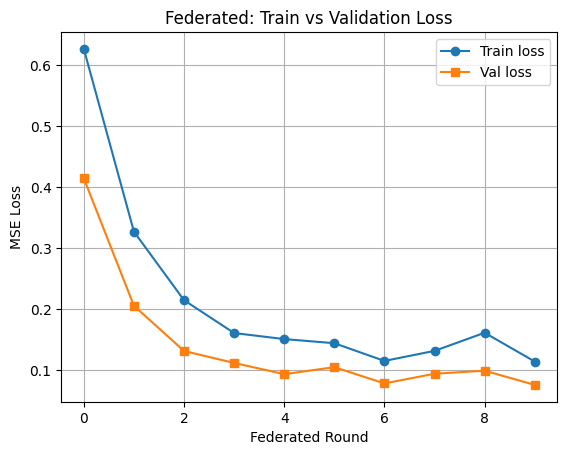

In [33]:
global_model, tr_losses, vd_losses = federated_train(
    ap_data,
    input_shape=(T_o, len(feature_cols)),
    rounds=10,
    clients_per_round=20,
    local_epochs=5,
    lr=1e-2,
    X_train_eval=X_train,
    y_train_eval=y_train,
    X_val=X_val,
    y_val=y_val,
)

# ── 5) Plot train vs val ────────────────────────────────────────────────
plt.plot(tr_losses, marker='o', label='Train loss')
plt.plot(vd_losses, marker='s', label='Val loss')
plt.xlabel('Federated Round')
plt.ylabel('MSE Loss')
plt.title('Federated: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
from sklearn.metrics import r2_score

# Predict on test set using the federated global model
y_pred_fed = global_model.predict(X_test)

# If y is 2D (e.g., (samples, T_p)), compute R² for each output
if y_pred_fed.shape[1] == 1 or len(y_pred_fed.shape) == 1:
    r2_fed = r2_score(y_test, y_pred_fed)
    print(f"Federated R² score: {r2_fed:.4f}")
else:
    for i in range(y_pred_fed.shape[1]):
        r2_fed = r2_score(y_test[:, i], y_pred_fed[:, i])
        print(f"Federated R² score for output {i}: {r2_fed:.4f}")

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Federated R² score: 0.8209


In [35]:
y_pred_un_normalized = scaler_y.inverse_transform(y_pred_fed)
y_true_un_normalized = scaler_y.inverse_transform(y_test)

mse  = mean_squared_error(y_true_un_normalized, y_pred_un_normalized)
mae  = mean_absolute_error(y_true_un_normalized, y_pred_un_normalized)
mape = mean_absolute_percentage_error(y_true_un_normalized, y_pred_un_normalized) * 100

print(f"Test MSE : {mse:.2f}")
print(f"Test MAE : {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")

Test MSE : 19398.90
Test MAE : 82.57
Test MAPE: 96.40%


# Comment on Federated Learning

In the federated learning setup, the model is trained collaboratively across multiple APs (clients), each performing local updates on its own data before aggregating the weights globally using FedAvg. This simulates a privacy-preserving, distributed training scenario.

Unlike the centralized approach, callbacks like EarlyStopping and ReduceLROnPlateau are not directly used, since training is orchestrated in rounds rather than epochs, and each round consists of several clients performing local training. 

We observe that the MSE loss decreases steadily over the federated rounds for both training and validation sets, indicating that the global model is learning effectively from the distributed data. The gap between training and validation loss remains small, suggesting good generalization and no significant overfitting.

Although the loss is higher, we consider that this is due to having it underfitted. But computationally speaking, federated learning takes more time (on our machine). 

The R² coefficient for the federated model, computed on the test set, demonstrates that the federated approach achieves competitive predictive performance compared to the centralized model. This shows that federated learning can be a viable alternative when data privacy or locality is a concern, with only a modest trade-off in accuracy.

### Exercise 6 (EXTRA):

Reconsider your design to improve the accuracy of your model. For that, you can find a better approach to split the data (e.g., using larger observation windows) and include additional features.

# Comment on exercise 6

Due to time constraints, we will discuss brievly what is necessary to do this exercise. This commes basically as a direct consequence from understanding the data and seeing what we have done.

It is important to notice that the time index has not played a role when working with this models. At certain hours, there might be some trend that makes more bites come through.

Another thing we should hanndle is the sparsity and skewness of the data. Most of the time, the values of this dataset are 0. What we could do, is to implement a pipeline of models. The first one (not ML necessarily, here discussing model as something we could add to preprocess the data) could add a new featured, called "active", only being a boolean 1 when transmitting 0 when not. This could help the ML model understand where to look at and where not.

Also regarding the big variance the data presents, we could add a log scale, in order to balance a bit more.

Also we have discussed the time observation windows, in the autocorrelation plots. A To = 5 is good enough to grab almost all of the correlation between the plots. A bigger such as 6 or 7 could be fine, but more does not add any information at all and only adds computational cost.